# Causal Inference
***

### Table of content

#### [Import Libraries and Initial Setting Up](#import)
#### [Read Preprocessed Data](#read)
#### [Treatment I: Inflight wifi service](#t1)
#### [Experiment I: Inflight wifi service](#e1)

1. [**S Learner** with XBGRegressor](#e1s)
2. [**T Learner** with XBGRegressor](#e1t)
3. [**X Learner** with XBGRegressor](#e1x)

#### [CATE I: Inflight wifi service](#c1)

1. [By **IsBusinessTravel**](#c1bu)
2. [By **IsLoyalCustomer**](#c1lo)
3. [By **Flight Distance**](#c1ds)
3. [Treatment Effect **Visualization**](#c1v)

#### [Treatment II: Online boarding](#t2)
#### [Experiment II: Online boarding](#e2)

1. [**S Learner** with XBGRegressor](#e2s)
2. [**T Learner** with XBGRegressor](#e2t)
3. [**X Learner** with XBGRegressor](#e2x)

#### [CATE II: Online boarding](#c2)

1. [By **IsBusinessTravel**](#c2bu)
2. [By **IsLoyalCustomer**](#c2lo)
3. [By **Age**](#c2age)
3. [Treatment Effect **Visualization**](#c2v)

<br>

***
<br>


## Import Libraries and Initial Setting Up<a name = "import"></a>

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import matplotlib as mpl
import seaborn as sns
import time

In [2]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from causalml.inference.meta import BaseSRegressor, BaseTRegressor, BaseXRegressor, BaseRRegressor, LRSRegressor, XGBTRegressor
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.dataset.regression import synthetic_data
from causalml.dataset import make_uplift_classification

from sklearn.linear_model import LinearRegression

/Users/ylfaliang/opt/anaconda3/lib/python3.8/site-packages/dask/dataframe/utils.py:369: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/Users/ylfaliang/opt/anaconda3/lib/python3.8/site-packages/dask/dataframe/utils.py:369: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/Users/ylfaliang/opt/anaconda3/lib/python3.8/site-packages/dask/dataframe/utils.py:369: FutureWarning: pandas.UInt64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)


In [3]:
import sys
import warnings
import pprint

warnings.filterwarnings("ignore")
pp = pprint.PrettyPrinter(compact=True)
pd.set_option('display.max_columns', None)

In [4]:
def make_pretty(styler):
    styler.background_gradient(cmap = sns.color_palette("vlag", as_cmap=True), axis = None)
    styler.format(lambda x: round(x,3))
    return styler

<br>

## Read Preprocessed Data<a name = "read"></a>

In [5]:
airplane = pd.read_csv('../preprocessing/data/airplane_train_processed.csv')
airplane_norm = pd.read_csv('../preprocessing/data/airplane_train_processed_normalized.csv')

In [6]:
display(airplane.head())
display(airplane_norm.head())

,Departure Delay in Minutes,Arrival Delay in Minutes,Gender_Female,Gender_Male,Customer Type_Loyal Customer,Customer Type_disloyal Customer,Type of Travel_Business travel,Type of Travel_Personal Travel,Class_Business,Class_Eco,Class_Eco Plus,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Age,Flight Distance,satisfaction
0,25.0,18.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,3.0,4.0,3.0,1.0,5.0,3.0,5.0,5.0,4.0,3.0,4.0,4.0,5.0,5.0,13,460,neutral or dissatisfied
1,1.0,6.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,3.0,2.0,3.0,3.0,1.0,3.0,1.0,1.0,1.0,5.0,3.0,1.0,4.0,1.0,25,235,neutral or dissatisfied
2,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,2.0,2.0,2.0,2.0,5.0,5.0,5.0,5.0,4.0,3.0,4.0,4.0,4.0,5.0,26,1142,satisfied
3,11.0,9.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,2.0,5.0,5.0,5.0,2.0,2.0,2.0,2.0,2.0,5.0,3.0,1.0,4.0,2.0,25,562,neutral or dissatisfied
4,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,3.0,3.0,3.0,3.0,4.0,5.0,5.0,3.0,3.0,4.0,4.0,3.0,3.0,3.0,61,214,satisfied


,Flight Distance,Departure Delay in Minutes,Arrival Delay in Minutes,Gender_Female,Gender_Male,Customer Type_Loyal Customer,Customer Type_disloyal Customer,Type of Travel_Business travel,Type of Travel_Personal Travel,Class_Business,Class_Eco,Class_Eco Plus,Age,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,satisfaction
0,6.133398,3.258097,2.944439,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,-1.746468,3.0,4.0,3.0,1.0,5.0,3.0,5.0,5.0,4.0,3.0,4.0,4.0,5.0,5.0,neutral or dissatisfied
1,5.463832,0.693147,1.945910,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,-0.951927,3.0,2.0,3.0,3.0,1.0,3.0,1.0,1.0,1.0,5.0,3.0,1.0,4.0,1.0,neutral or dissatisfied
2,7.041412,0.000000,0.000000,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,-0.885715,2.0,2.0,2.0,2.0,5.0,5.0,5.0,5.0,4.0,3.0,4.0,4.0,4.0,5.0,satisfied
3,6.333280,2.484907,2.302585,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,-0.951927,2.0,5.0,5.0,5.0,2.0,2.0,2.0,2.0,2.0,5.0,3.0,1.0,4.0,2.0,neutral or dissatisfied
4,5.370638,0.000000,0.000000,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.431697,3.0,3.0,3.0,3.0,4.0,5.0,5.0,3.0,3.0,4.0,4.0,3.0,3.0,3.0,satisfied


In [7]:
for col in ["Gender_Male","Customer Type_Loyal Customer","Type of Travel_Business travel"]:
    display(pd.DataFrame(airplane[col].value_counts(normalize = True)).rename(index = {0:"No",1:"Yes"}))

,Gender_Male
No,0.507357
Yes,0.492643


,Customer Type_Loyal Customer
Yes,0.816951
No,0.183049


,Type of Travel_Business travel
Yes,0.689492
No,0.310508


In [8]:
airplane_causal = airplane.copy()
airplane_causal.rename(columns = {"Gender_Male":"IsMale",
                                  "Customer Type_Loyal Customer":"IsLoyalCustomer",
                                  "Type of Travel_Business travel":"IsBusinessTravel"}, 
                       inplace = True)

airplane_causal.drop(columns = ["Gender_Female","Customer Type_disloyal Customer","Type of Travel_Personal Travel"], 
                     inplace = True)

In [9]:
display(airplane_causal.head())

,Departure Delay in Minutes,Arrival Delay in Minutes,IsMale,IsLoyalCustomer,IsBusinessTravel,Class_Business,Class_Eco,Class_Eco Plus,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Age,Flight Distance,satisfaction
0,25.0,18.0,1.0,1.0,0.0,0.0,0.0,1.0,3.0,4.0,3.0,1.0,5.0,3.0,5.0,5.0,4.0,3.0,4.0,4.0,5.0,5.0,13,460,neutral or dissatisfied
1,1.0,6.0,1.0,0.0,1.0,1.0,0.0,0.0,3.0,2.0,3.0,3.0,1.0,3.0,1.0,1.0,1.0,5.0,3.0,1.0,4.0,1.0,25,235,neutral or dissatisfied
2,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,2.0,2.0,2.0,2.0,5.0,5.0,5.0,5.0,4.0,3.0,4.0,4.0,4.0,5.0,26,1142,satisfied
3,11.0,9.0,0.0,1.0,1.0,1.0,0.0,0.0,2.0,5.0,5.0,5.0,2.0,2.0,2.0,2.0,2.0,5.0,3.0,1.0,4.0,2.0,25,562,neutral or dissatisfied
4,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,3.0,3.0,3.0,3.0,4.0,5.0,5.0,3.0,3.0,4.0,4.0,3.0,3.0,3.0,61,214,satisfied


<br>

## Treatment I: Inflight wifi service<a name = "t1"></a>
<br>

- **Target**: *satisfication*

In [10]:
display(pd.DataFrame(airplane_causal["satisfaction"].value_counts(normalize = True)))
airplane_causal["satisfaction"] = np.where(airplane_causal["satisfaction"] == "satisfied", 1, 0)

y = airplane_causal["satisfaction"]

,satisfaction
neutral or dissatisfied,0.566263
satisfied,0.433737


<br>

- **Treatment**: *Good Wifi Service*<br>**Control**: *Bad Wifi Service*

In [11]:
treatment =  pd.Series(np.where(airplane_causal["Inflight wifi service"] >= 4,
                                "Good Wifi Service", "Bad Wifi Service"), name = "Inflight wifi service")
display(pd.DataFrame(treatment.value_counts(normalize = True)))

,Inflight wifi service
Bad Wifi Service,0.695512
Good Wifi Service,0.304488


<br>

- **Other features**

In [12]:
X = airplane_causal.drop(["satisfaction", "Inflight wifi service"], axis = 1)
display(X.head())

,Departure Delay in Minutes,Arrival Delay in Minutes,IsMale,IsLoyalCustomer,IsBusinessTravel,Class_Business,Class_Eco,Class_Eco Plus,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Age,Flight Distance
0,25.0,18.0,1.0,1.0,0.0,0.0,0.0,1.0,4.0,3.0,1.0,5.0,3.0,5.0,5.0,4.0,3.0,4.0,4.0,5.0,5.0,13,460
1,1.0,6.0,1.0,0.0,1.0,1.0,0.0,0.0,2.0,3.0,3.0,1.0,3.0,1.0,1.0,1.0,5.0,3.0,1.0,4.0,1.0,25,235
2,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,2.0,2.0,2.0,5.0,5.0,5.0,5.0,4.0,3.0,4.0,4.0,4.0,5.0,26,1142
3,11.0,9.0,0.0,1.0,1.0,1.0,0.0,0.0,5.0,5.0,5.0,2.0,2.0,2.0,2.0,2.0,5.0,3.0,1.0,4.0,2.0,25,562
4,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,3.0,3.0,3.0,4.0,5.0,5.0,3.0,3.0,4.0,4.0,3.0,3.0,3.0,61,214


<br>

<font color="mediumorchid">*Check feature names*</font>

In [13]:
feature_names = list(X.columns)
print("Number of features: " + str(len(feature_names)) + "\n")
pp.pprint(feature_names)

Number of features: 23

['Departure Delay in Minutes', 'Arrival Delay in Minutes', 'IsMale',
 'IsLoyalCustomer', 'IsBusinessTravel', 'Class_Business', 'Class_Eco',
 'Class_Eco Plus', 'Departure/Arrival time convenient',
 'Ease of Online booking', 'Gate location', 'Food and drink', 'Online boarding',
 'Seat comfort', 'Inflight entertainment', 'On-board service',
 'Leg room service', 'Baggage handling', 'Checkin service', 'Inflight service',
 'Cleanliness', 'Age', 'Flight Distance']


<br>

<font color="mediumorchid">*Length check*</font>

In [14]:
print("Length check pass?",len(y) == len(treatment) == len(X))

Length check pass? True


## Experiment I: Inflight wifi service<a name = "e1"></a>

In [15]:
comparison = pd.DataFrame(columns = ["Meta Learner", 
                                     "Base Model (Regressor)", 
                                     "ATE", 
                                     "ATE lb", 
                                     "ATE ub",
                                     "Top Features (auto)"])

In [16]:
display(pd.concat([airplane_causal["satisfaction"], treatment], 
                  axis = 1).pivot_table(values = "satisfaction",
                                        index = "Inflight wifi service",
                                        aggfunc = [np.mean, np.size],
                                        margins = True))

,mean,size
,satisfaction,satisfaction
Inflight wifi service,,
Bad Wifi Service,0.297136,71516
Good Wifi Service,0.745760,31309
All,0.433737,102825


### 1. S Learner with XGBRegressor<a name = "e1s"></a>

In [17]:
s_learner = BaseSRegressor(XGBRegressor(n_jobs = -1), control_name = "Bad Wifi Service")
te = s_learner.estimate_ate(X, treatment, y)
result = ["S Learner", "XGBoost", te[0], "NA", "NA"]

In [18]:
s_learner_tau = s_learner.fit_predict(X, treatment, y)

importance = s_learner.get_importance(X = X,
                                      tau = s_learner_tau,
                                      normalize = True, 
                                      method = "auto", 
                                      features = feature_names)

display(pd.DataFrame(importance).rename(columns = {"Good Wifi Service":"Importance"}))
result.append(list(pd.DataFrame(importance).iloc[:3,0].index))

,Importance
Online boarding,0.284020
Departure/Arrival time convenient,0.155934
Class_Business,0.123419
Inflight entertainment,0.073185
Gate location,0.063924
Ease of Online booking,0.058942
Flight Distance,0.051369
IsLoyalCustomer,0.042309
IsBusinessTravel,0.041083
Arrival Delay in Minutes,0.031690


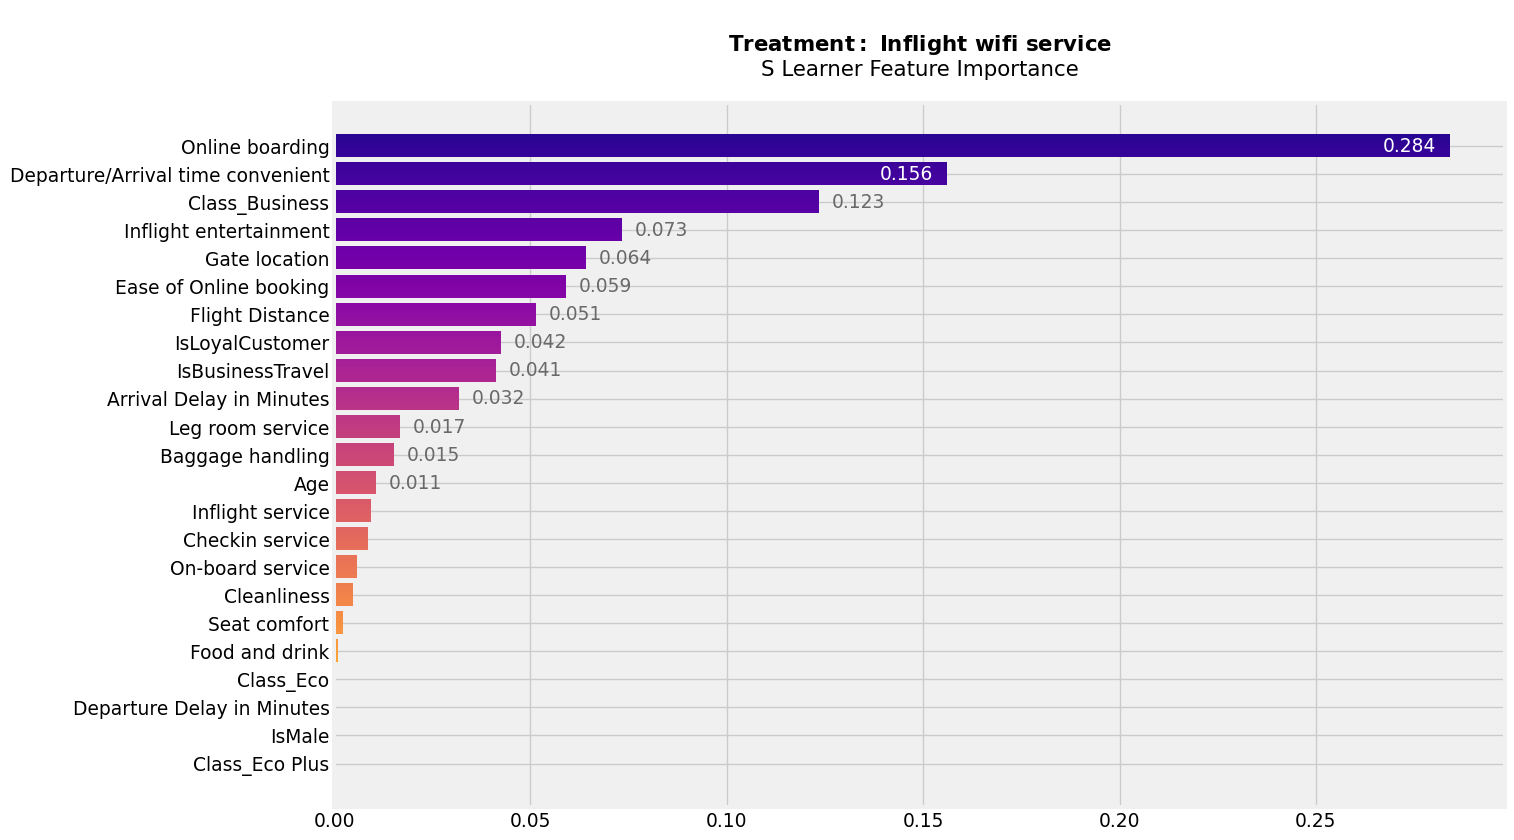

In [19]:
fig, ax = plt.subplots(figsize=(16,8), dpi = 96, facecolor = "white")

bar = ax.barh(importance["Good Wifi Service"].index, importance["Good Wifi Service"], color = "olivedrab")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.title("\n"+r"$\bf{Treatment:\ Inflight\ wifi\ service}$"+"\n"+"S Learner Feature Importance", pad=20, fontsize=16)
ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:.2f}'))

def gradientbars_sliced(bars):
    ax = bars[0].axes
    xmin, xmax = ax.get_xlim()
    ymax, ymin = ax.get_ylim()
    for bar in bars:
        bar.set_zorder(1)
        bar.set_facecolor("none")
        x, y = bar.get_xy()
        w, h = bar.get_width(), bar.get_height()
        grad = np.linspace(y, y + h, 256).reshape(256, 1)
        ax.imshow(grad, extent=[x, x + w, y, y + h], aspect="auto", zorder=1, origin='lower',
                  vmin=ymin, vmax=ymax, cmap="plasma")
    ax.axis([xmin, xmax, ymax, ymin])

gradientbars_sliced(bar)

for rect in ax.patches:
    x_value = rect.get_width()
    y_value = rect.get_y() + rect.get_height() / 2
    if x_value > 0.01:
        if x_value < 0.15:
            space = 50
            ha = 'right'
            color = "dimgrey"
        else:
            space = -50
            ha = 'left'
            color = "white"

        label = '{:,.3f}'.format(x_value)

        plt.annotate(label, (x_value, y_value), xytext=(space, 0), textcoords='offset points',
                     va='center', ha=ha, color = color)

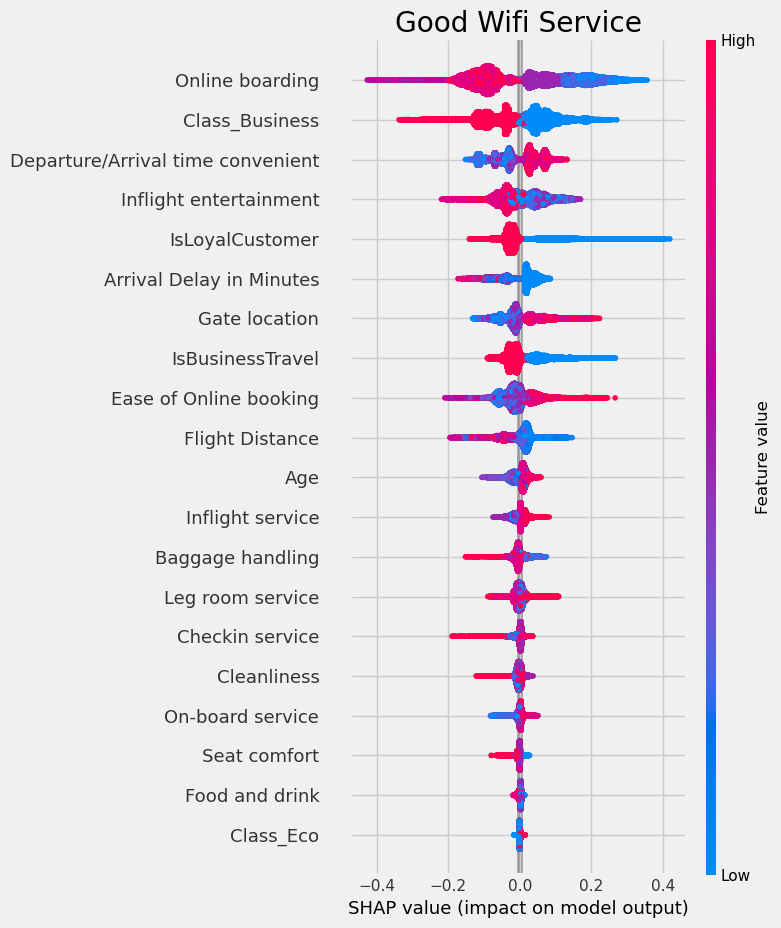

In [20]:
s_learner.plot_shap_values(X=X, tau=s_learner_tau, features=feature_names)

In [21]:
comparison.loc[len(comparison)] = result
display(comparison)

,Meta Learner,Base Model (Regressor),ATE,ATE lb,ATE ub,Top Features (auto)
0,S Learner,XGBoost,0.182478,NA,NA,"[Online boarding, Departure/Arrival time conve..."


### 2. T Learner with XGBTRegressor<a name = "e1t"></a>

In [22]:
t_learner = XGBTRegressor(control_name = "Bad Wifi Service")
te, lb, ub = t_learner.estimate_ate(X, treatment, y)
result = ["T Learner", "XGBoost", te[0], lb[0], ub[0]]

In [23]:
t_learner_tau = t_learner.fit_predict(X, treatment, y)

importance = t_learner.get_importance(X = X,
                                      tau = t_learner_tau,
                                      normalize = True, 
                                      method = 'auto', 
                                      features = feature_names)
display(pd.DataFrame(importance).rename(columns = {"Good Wifi Service":"Importance"}))
result.append(list(pd.DataFrame(importance).iloc[:3,0].index))

,Importance
Departure/Arrival time convenient,0.189474
Class_Business,0.184406
Online boarding,0.136711
IsLoyalCustomer,0.123114
Ease of Online booking,0.072502
Inflight entertainment,0.062487
Gate location,0.047671
IsBusinessTravel,0.035017
Arrival Delay in Minutes,0.026298
Baggage handling,0.023638


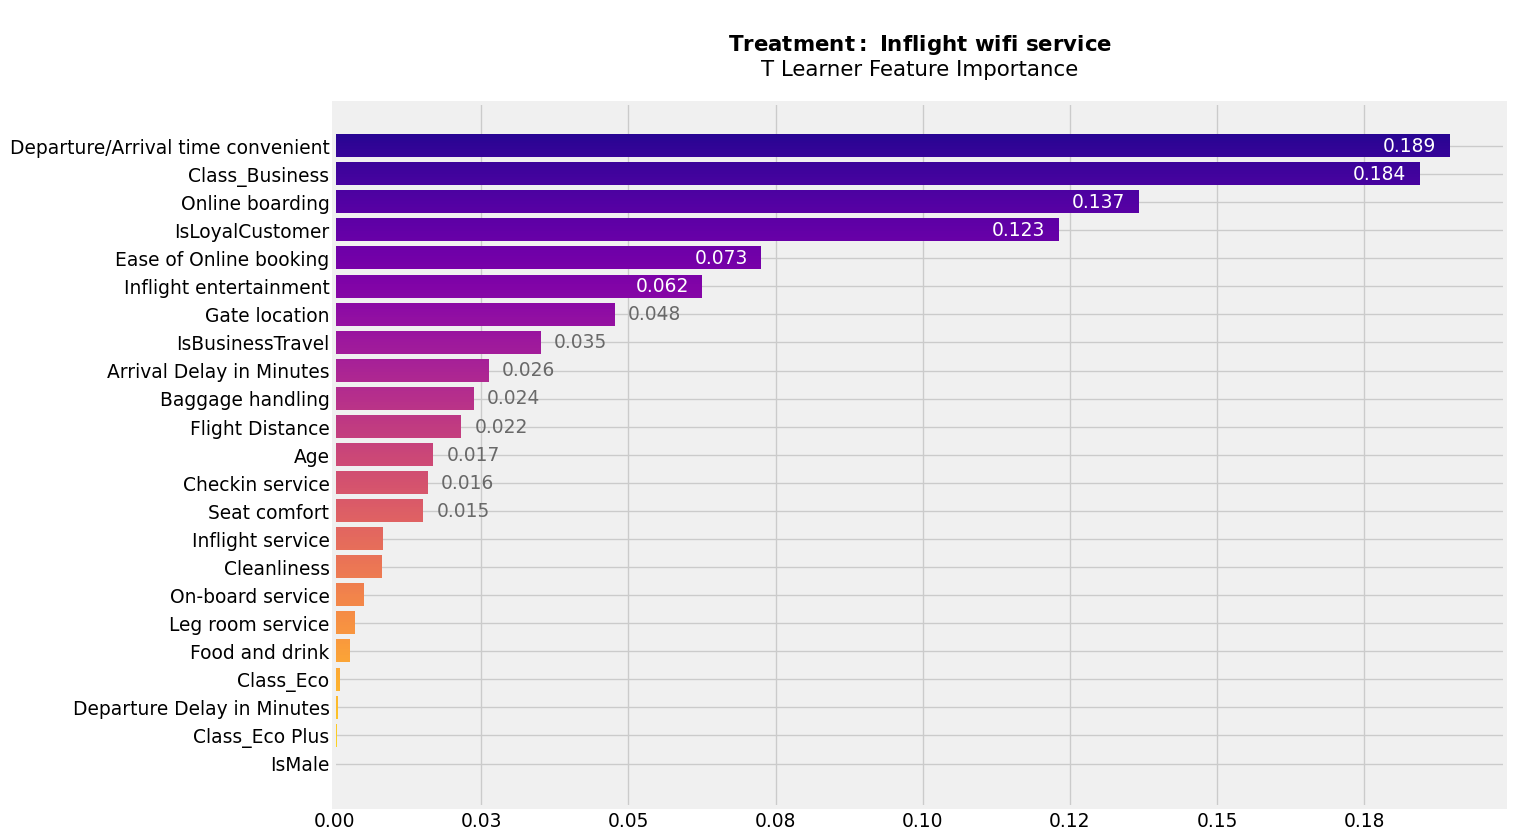

In [24]:
fig, ax = plt.subplots(figsize=(16,8), dpi = 96, facecolor = "white")

bar = ax.barh(importance["Good Wifi Service"].index, importance["Good Wifi Service"], color = "olivedrab")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.title("\n"+r"$\bf{Treatment:\ Inflight\ wifi\ service}$"+"\n"+"T Learner Feature Importance", pad=20, fontsize=16)
ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:.2f}'))

def gradientbars_sliced(bars):
    ax = bars[0].axes
    xmin, xmax = ax.get_xlim()
    ymax, ymin = ax.get_ylim()
    for bar in bars:
        bar.set_zorder(1)
        bar.set_facecolor("none")
        x, y = bar.get_xy()
        w, h = bar.get_width(), bar.get_height()
        grad = np.linspace(y, y + h, 256).reshape(256, 1)
        ax.imshow(grad, extent=[x, x + w, y, y + h], aspect="auto", zorder=1, origin='lower',
                  vmin=ymin, vmax=ymax, cmap="plasma")
    ax.axis([xmin, xmax, ymax, ymin])

gradientbars_sliced(bar)

for rect in ax.patches:
    x_value = rect.get_width()
    y_value = rect.get_y() + rect.get_height() / 2
    if x_value > 0.01:
        if x_value < 0.05:
            space = 50
            ha = 'right'
            color = "dimgrey"
        else:
            space = -50
            ha = 'left'
            color = "white"

        label = '{:,.3f}'.format(x_value)

        plt.annotate(label, (x_value, y_value), xytext=(space, 0), textcoords='offset points',
                     va='center', ha=ha, color = color)

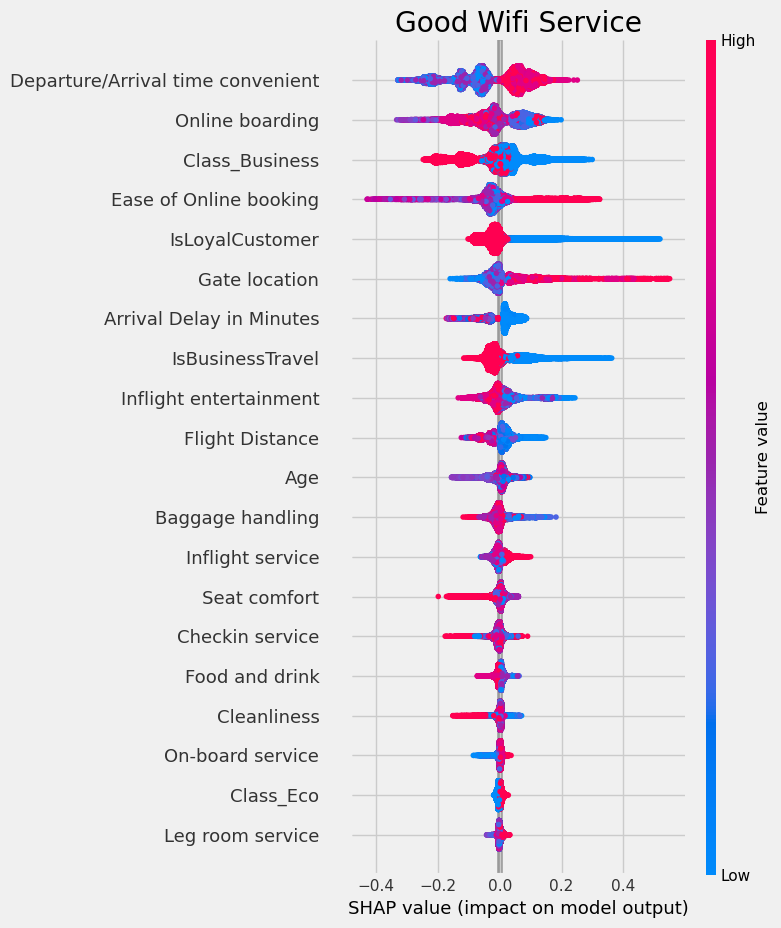

In [25]:
t_learner.plot_shap_values(X = X, tau = t_learner_tau, features = feature_names)

In [26]:
comparison.loc[len(comparison)] = result
display(comparison)

,Meta Learner,Base Model (Regressor),ATE,ATE lb,ATE ub,Top Features (auto)
0,S Learner,XGBoost,0.182478,NA,NA,"[Online boarding, Departure/Arrival time conve..."
1,T Learner,XGBoost,0.222909,0.219242,0.226575,"[Departure/Arrival time convenient, Class_Busi..."


### 3. X Learner with XGBRegressor<a name = "e1x"></a>

In [27]:
x_learner = BaseXRegressor(XGBRegressor(n_jobs = -1), control_name = "Bad Wifi Service")
te, lb, ub = x_learner.estimate_ate(X, treatment, y)
result = ["X Learner", "XGBoost", te[0], lb[0], ub[0]]

In [28]:
x_learner_tau = x_learner.fit_predict(X, treatment, y)

importance = x_learner.get_importance(X = X,
                                      tau = x_learner_tau,
                                      normalize = True, 
                                      method = 'auto', 
                                      features = feature_names)
display(pd.DataFrame(importance).rename(columns = {"Good Wifi Service":"Importance"}))
result.append(list(pd.DataFrame(importance).iloc[:3,0].index))

,Importance
Class_Business,0.279574
Departure/Arrival time convenient,0.248458
IsLoyalCustomer,0.143072
Inflight entertainment,0.087229
Ease of Online booking,0.050138
Online boarding,0.048817
Gate location,0.037000
IsBusinessTravel,0.020664
Arrival Delay in Minutes,0.020040
Age,0.017930


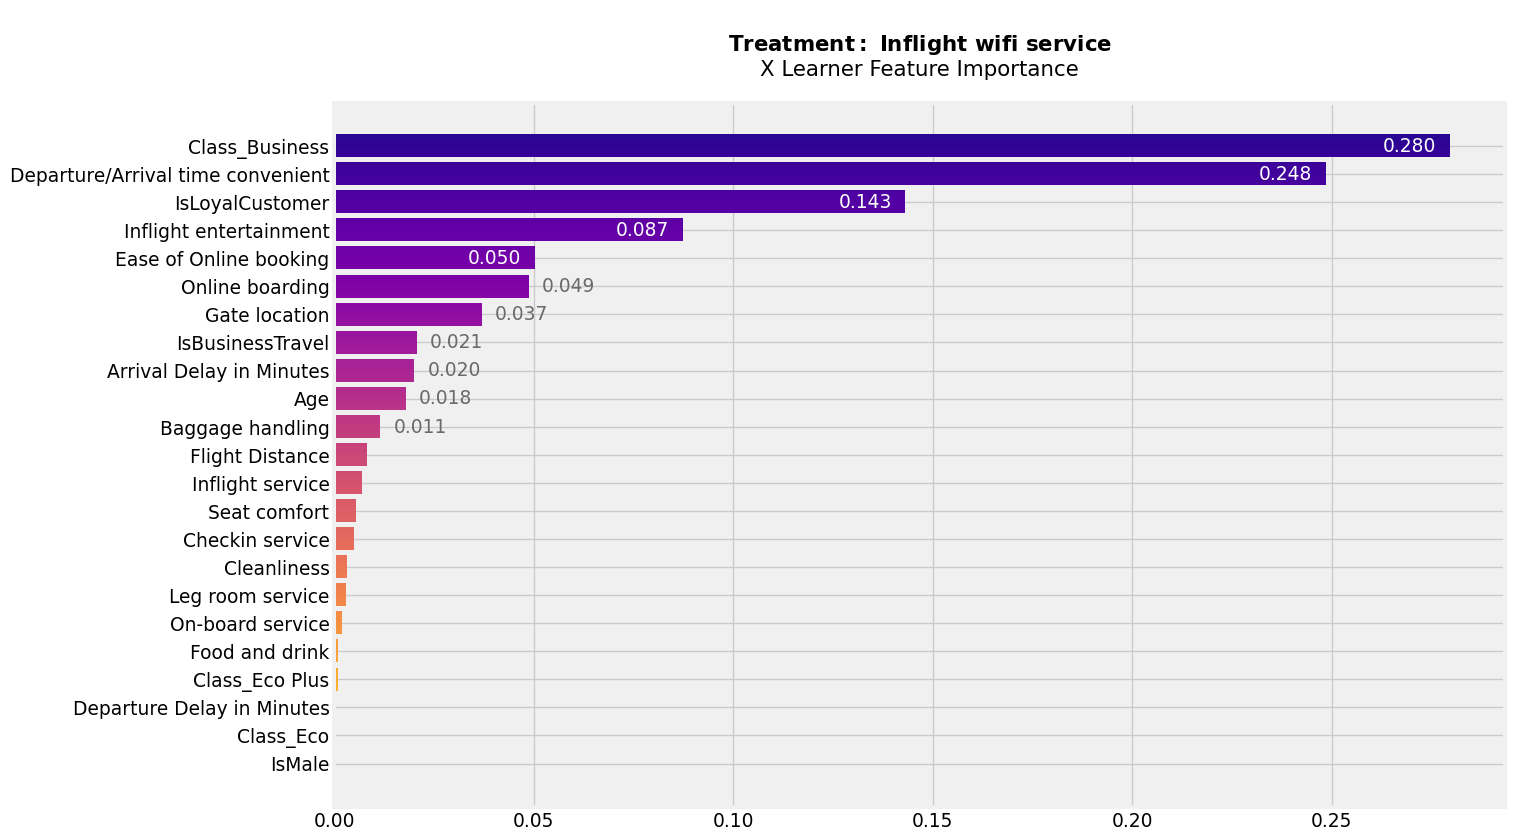

In [29]:
fig, ax = plt.subplots(figsize=(16,8), dpi = 96, facecolor = "white")

bar = ax.barh(importance["Good Wifi Service"].index, importance["Good Wifi Service"], color = "olivedrab")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.title("\n"+r"$\bf{Treatment:\ Inflight\ wifi\ service}$"+"\n"+"X Learner Feature Importance", pad=20, fontsize=16)
ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:.2f}'))

def gradientbars_sliced(bars):
    ax = bars[0].axes
    xmin, xmax = ax.get_xlim()
    ymax, ymin = ax.get_ylim()
    for bar in bars:
        bar.set_zorder(1)
        bar.set_facecolor("none")
        x, y = bar.get_xy()
        w, h = bar.get_width(), bar.get_height()
        grad = np.linspace(y, y + h, 256).reshape(256, 1)
        ax.imshow(grad, extent=[x, x + w, y, y + h], aspect="auto", zorder=1, origin='lower',
                  vmin=ymin, vmax=ymax, cmap="plasma")
    ax.axis([xmin, xmax, ymax, ymin])

gradientbars_sliced(bar)

for rect in ax.patches:
    x_value = rect.get_width()
    y_value = rect.get_y() + rect.get_height() / 2
    if x_value > 0.01:
        if x_value < 0.05:
            space = 50
            ha = 'right'
            color = "dimgrey"
        else:
            space = -50
            ha = 'left'
            color = "white"

        label = '{:,.3f}'.format(x_value)

        plt.annotate(label, (x_value, y_value), xytext=(space, 0), textcoords='offset points',
                     va='center', ha=ha, color = color)

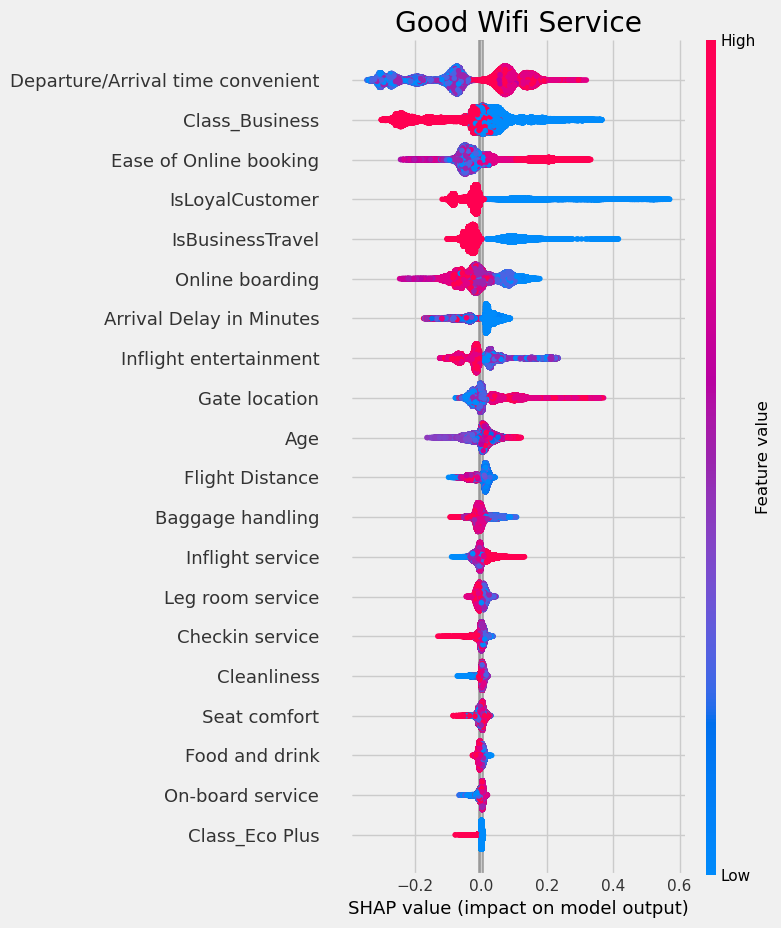

In [30]:
x_learner.plot_shap_values(X = X, tau = x_learner_tau, features = feature_names)

In [31]:
comparison.loc[len(comparison)] = result
pd.set_option('display.max_colwidth', None)
display(comparison)

,Meta Learner,Base Model (Regressor),ATE,ATE lb,ATE ub,Top Features (auto)
0,S Learner,XGBoost,0.182478,NA,NA,"[Online boarding, Departure/Arrival time convenient, Class_Business]"
1,T Learner,XGBoost,0.222909,0.219242,0.226575,"[Departure/Arrival time convenient, Class_Business, Online boarding]"
2,X Learner,XGBoost,0.172485,0.168689,0.17628,"[Class_Business, Departure/Arrival time convenient, IsLoyalCustomer]"


## CATE I: Inflight wifi service<a name = "c1"></a>

In [32]:
airplane_ITE_t = t_learner.fit_predict(X, treatment, y)
display(airplane_ITE_t)

array([[-0.07424118],
       [-0.04281987],
       [-0.10966891],
       ...,
       [ 0.43994117],
       [ 0.6570431 ],
       [ 0.05436207]])

In [33]:
airplane_causal["ITE"] = airplane_ITE_t
display(airplane_causal.head())

,Departure Delay in Minutes,Arrival Delay in Minutes,IsMale,IsLoyalCustomer,IsBusinessTravel,Class_Business,Class_Eco,Class_Eco Plus,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Age,Flight Distance,satisfaction,ITE
0,25.0,18.0,1.0,1.0,0.0,0.0,0.0,1.0,3.0,4.0,3.0,1.0,5.0,3.0,5.0,5.0,4.0,3.0,4.0,4.0,5.0,5.0,13,460,0,-0.074241
1,1.0,6.0,1.0,0.0,1.0,1.0,0.0,0.0,3.0,2.0,3.0,3.0,1.0,3.0,1.0,1.0,1.0,5.0,3.0,1.0,4.0,1.0,25,235,0,-0.042820
2,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,2.0,2.0,2.0,2.0,5.0,5.0,5.0,5.0,4.0,3.0,4.0,4.0,4.0,5.0,26,1142,1,-0.109669
3,11.0,9.0,0.0,1.0,1.0,1.0,0.0,0.0,2.0,5.0,5.0,5.0,2.0,2.0,2.0,2.0,2.0,5.0,3.0,1.0,4.0,2.0,25,562,0,0.897127
4,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,3.0,3.0,3.0,3.0,4.0,5.0,5.0,3.0,3.0,4.0,4.0,3.0,3.0,3.0,61,214,1,-0.112429


### 1. By IsBusinessTravel<a name = "c1bu"></a>

In [34]:
CATE_bu = airplane_causal[["IsBusinessTravel", "ITE"]]
CATE_bu["IsBusinessTravel"] = np.where(CATE_bu["IsBusinessTravel"] == 1, "Yes", "No")
CATE_bu.groupby(["IsBusinessTravel"]).mean().rename(columns={"ITE":"CATE"}).style.pipe(make_pretty)

,CATE
IsBusinessTravel,
No,0.356
Yes,0.163


### 2. By IsLoyalCustomer<a name = "c1lo"></a>

In [35]:
CATE_lo = airplane_causal[["IsLoyalCustomer", "ITE"]]
CATE_lo["IsLoyalCustomer"] = np.where(CATE_lo["IsLoyalCustomer"] == 1, "Yes", "No")
CATE_lo.groupby(["IsLoyalCustomer"]).mean().rename(columns={"ITE":"CATE"}).style.pipe(make_pretty)

,CATE
IsLoyalCustomer,
No,0.374
Yes,0.189


### 3. By Flight Distance<a name = "c1ds"></a>

In [36]:
CATE_ds = airplane_causal[["Flight Distance", "ITE"]]
def flightDist(x):
    if x/560 < 3:
        return "Short"
    else:
        return "Mid-Long"
CATE_ds["Flight Distance"] = CATE_ds["Flight Distance"].apply(lambda x: flightDist(x))
CATE_ds.groupby(["Flight Distance"]).mean().rename(columns={"ITE":"CATE"}).style.pipe(make_pretty)

,CATE
Flight Distance,
Mid-Long,0.048
Short,0.284


### 4. Treatment Effect Visualization<a name = "c1v"></a>

In [37]:
CATE_vs = airplane_causal[["Flight Distance", "Age", "ITE"]]
CATE_vs["Flight Distance"] = CATE_vs["Flight Distance"].apply(lambda x: round(x/100)*100)
CATE_vs = CATE_vs.groupby(by = ["Flight Distance","Age"]).mean().reset_index()

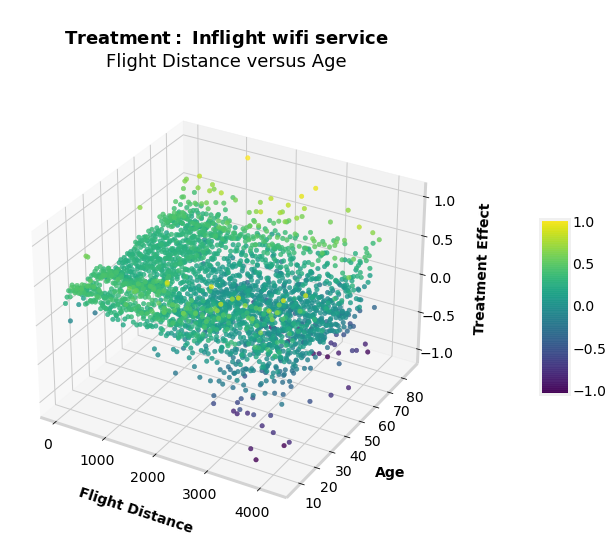

In [38]:
fig = plt.figure(figsize = (10, 10), dpi = 72)
ax = plt.axes(projection ="3d")

ax.grid(b = True, color ='grey', linestyle ='-.', linewidth = 0.3, alpha = 0.2)
my_cmap = plt.get_cmap('viridis')
 
sctt = ax.scatter3D(CATE_vs["Flight Distance"], CATE_vs["Age"], CATE_vs["ITE"],
                    alpha = 0.8,
                    c = CATE_vs["ITE"],
                    cmap = my_cmap)
 
plt.title("\n"+r"$\bf{Treatment:\ Inflight\ wifi\ service}$"+"\n"+"Flight Distance versus Age", pad=20, fontsize=18)

fig.set_facecolor("white")

ax.set_facecolor("white")
ax.w_xaxis.line.set_color("lightgrey")
ax.w_yaxis.line.set_color("lightgrey")
ax.w_zaxis.line.set_color("lightgrey")

ax.set_xlabel('\nFlight Distance', fontweight ='bold', fontsize = 14, labelpad = 12)
ax.set_ylabel('\nAge', fontweight ='bold', fontsize = 14, labelpad = 12)
ax.set_zlabel('\nTreatment Effect', fontweight ='bold', fontsize = 14, labelpad = 12)
fig.colorbar(sctt, ax = ax, shrink = 0.3, aspect = 6, pad = 0.15)

plt.show()

## Treatment II: Online boarding<a name = "t2"></a>

<br>

- **Target**: *satisfication* (stay the same)<br><br>
- **Treatment**: *Good Wifi Service*<br>**Control**: *Bad Wifi Service*

In [39]:
treatment =  pd.Series(np.where(airplane_causal["Online boarding"] >= 4,
                                "Good Online Boarding", "Bad Online Boarding"), name = "Online boarding")
display(pd.DataFrame(treatment.value_counts(normalize = True)))

,Online boarding
Bad Online Boarding,0.502446
Good Online Boarding,0.497554


- **Other features**

In [40]:
X = airplane_causal.drop(["satisfaction", "Online boarding", "ITE"], axis = 1)
display(X.head())

,Departure Delay in Minutes,Arrival Delay in Minutes,IsMale,IsLoyalCustomer,IsBusinessTravel,Class_Business,Class_Eco,Class_Eco Plus,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Age,Flight Distance
0,25.0,18.0,1.0,1.0,0.0,0.0,0.0,1.0,3.0,4.0,3.0,1.0,5.0,5.0,5.0,4.0,3.0,4.0,4.0,5.0,5.0,13,460
1,1.0,6.0,1.0,0.0,1.0,1.0,0.0,0.0,3.0,2.0,3.0,3.0,1.0,1.0,1.0,1.0,5.0,3.0,1.0,4.0,1.0,25,235
2,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,2.0,2.0,2.0,2.0,5.0,5.0,5.0,4.0,3.0,4.0,4.0,4.0,5.0,26,1142
3,11.0,9.0,0.0,1.0,1.0,1.0,0.0,0.0,2.0,5.0,5.0,5.0,2.0,2.0,2.0,2.0,5.0,3.0,1.0,4.0,2.0,25,562
4,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,3.0,3.0,3.0,3.0,4.0,5.0,3.0,3.0,4.0,4.0,3.0,3.0,3.0,61,214


<br>

<font color="mediumorchid">*Check feature names*</font>

In [41]:
feature_names = list(X.columns)
print("Number of features: " + str(len(feature_names)) + "\n")
pp.pprint(feature_names)

Number of features: 23

['Departure Delay in Minutes', 'Arrival Delay in Minutes', 'IsMale',
 'IsLoyalCustomer', 'IsBusinessTravel', 'Class_Business', 'Class_Eco',
 'Class_Eco Plus', 'Inflight wifi service', 'Departure/Arrival time convenient',
 'Ease of Online booking', 'Gate location', 'Food and drink', 'Seat comfort',
 'Inflight entertainment', 'On-board service', 'Leg room service',
 'Baggage handling', 'Checkin service', 'Inflight service', 'Cleanliness',
 'Age', 'Flight Distance']


<br>

<font color="mediumorchid">*Length Check*</font>

In [42]:
print("Length check pass?",len(y) == len(treatment) == len(X))

Length check pass? True


## Experiment II: Online boarding<a name = "e2"></a>

In [43]:
comparison = pd.DataFrame(columns = ["Meta Learner", 
                                     "Base Model (Regressor)", 
                                     "ATE", 
                                     "ATE lb", 
                                     "ATE ub",
                                     "Top Features (auto)"])

In [44]:
display(pd.concat([airplane_causal["satisfaction"], treatment], 
                  axis = 1).pivot_table(values = "satisfaction",
                                        index = "Online boarding",
                                        aggfunc = [np.mean, np.size],
                                        margins = True))

,mean,size
,satisfaction,satisfaction
Online boarding,,
Bad Online Boarding,0.145614,51664
Good Online Boarding,0.724693,51161
All,0.433737,102825


### 1. S Learner with XGBRegressor<a name = "e2s"></a>

In [45]:
s_learner = BaseSRegressor(XGBRegressor(n_jobs = -1), control_name = "Bad Online Boarding")
te = s_learner.estimate_ate(X, treatment, y)
result = ["S Learner", "XGBoost", te[0], "NA", "NA"]

In [46]:
s_learner_tau = s_learner.fit_predict(X, treatment, y)

importance = s_learner.get_importance(X = X,
                                      tau = s_learner_tau,
                                      normalize = True, 
                                      method = "auto", 
                                      features = feature_names)

display(pd.DataFrame(importance).rename(columns = {"Good Online Boarding":"Importance"}))
result.append(list(pd.DataFrame(importance).iloc[:3,0].index))

,Importance
Inflight wifi service,0.167489
IsLoyalCustomer,0.157196
IsBusinessTravel,0.098412
Inflight entertainment,0.070061
Seat comfort,0.069359
Leg room service,0.063545
Checkin service,0.063511
Cleanliness,0.059918
Ease of Online booking,0.042676
Class_Business,0.039528


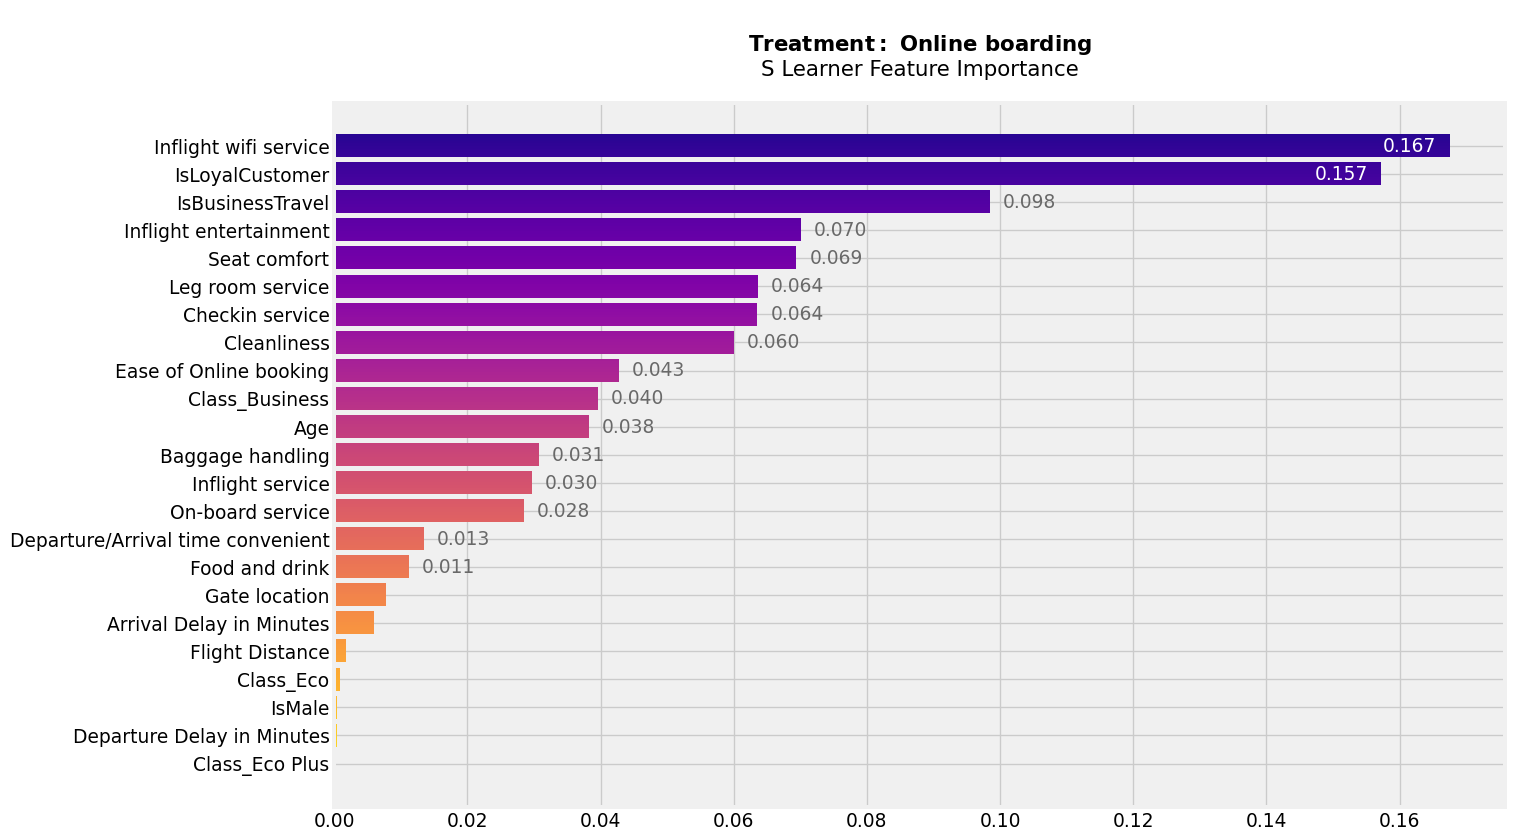

In [47]:
fig, ax = plt.subplots(figsize=(16,8), dpi = 96, facecolor = "white")

bar = ax.barh(importance["Good Online Boarding"].index, importance["Good Online Boarding"])
plt.gca().invert_yaxis()
plt.tight_layout()
plt.title("\n"+r"$\bf{Treatment:\ Online\ boarding}$"+"\n"+"S Learner Feature Importance", pad=20, fontsize=16)
ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:.2f}'))

def gradientbars_sliced(bars):
    ax = bars[0].axes
    xmin, xmax = ax.get_xlim()
    ymax, ymin = ax.get_ylim()
    for bar in bars:
        bar.set_zorder(1)
        bar.set_facecolor("none")
        x, y = bar.get_xy()
        w, h = bar.get_width(), bar.get_height()
        grad = np.linspace(y, y + h, 256).reshape(256, 1)
        ax.imshow(grad, extent=[x, x + w, y, y + h], aspect="auto", zorder=1, origin='lower',
                  vmin=ymin, vmax=ymax, cmap="plasma")
    ax.axis([xmin, xmax, ymax, ymin])

gradientbars_sliced(bar)

for rect in ax.patches:
    x_value = rect.get_width()
    y_value = rect.get_y() + rect.get_height() / 2
    if x_value > 0.01:
        if x_value < 0.15:
            space = 50
            ha = 'right'
            color = "dimgrey"
        else:
            space = -50
            ha = 'left'
            color = "white"

        label = '{:,.3f}'.format(x_value)

        plt.annotate(label, (x_value, y_value), xytext=(space, 0), textcoords='offset points',
                     va='center', ha=ha, color = color)

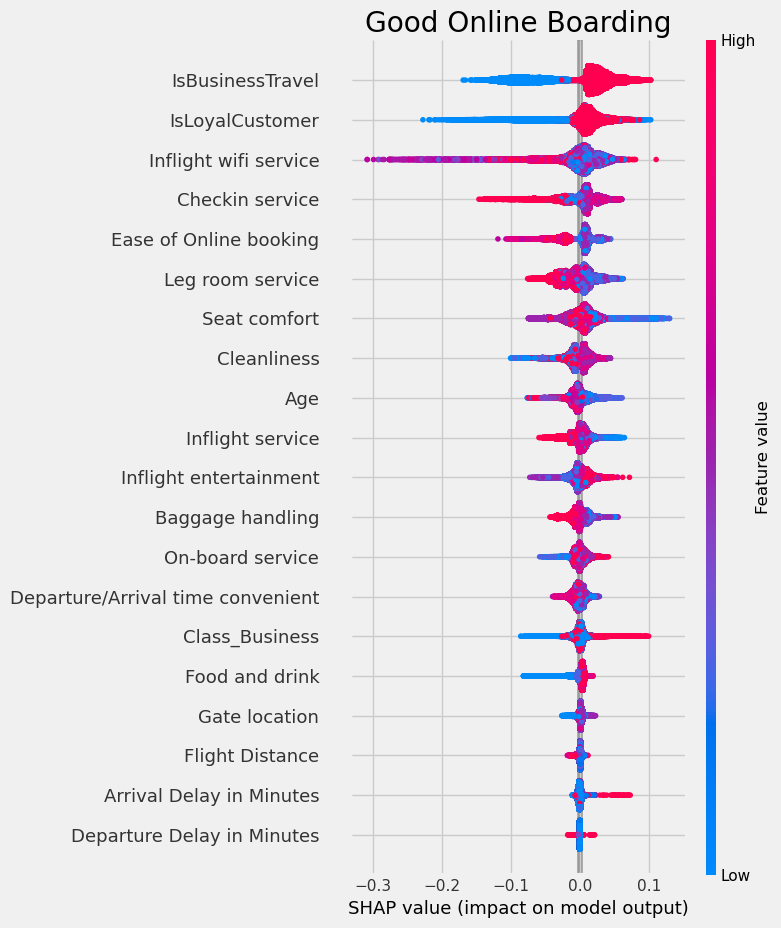

In [48]:
s_learner.plot_shap_values(X=X, tau=s_learner_tau, features=feature_names)

In [49]:
comparison.loc[len(comparison)] = result
display(comparison)

,Meta Learner,Base Model (Regressor),ATE,ATE lb,ATE ub,Top Features (auto)
0,S Learner,XGBoost,0.058765,NA,NA,"[Inflight wifi service, IsLoyalCustomer, IsBusinessTravel]"


### 2. T Learner with XGBTRegressor<a name = "e2t"></a>

In [50]:
t_learner = XGBTRegressor(control_name = "Bad Online Boarding")
te, lb, ub = t_learner.estimate_ate(X, treatment, y)
result = ["T Learner", "XGBoost", te[0], lb[0], ub[0]]

In [51]:
t_learner_tau = t_learner.fit_predict(X, treatment, y)

importance = t_learner.get_importance(X = X,
                                      tau = t_learner_tau,
                                      normalize = True, 
                                      method = 'auto', 
                                      features = feature_names)
display(pd.DataFrame(importance).rename(columns = {"Good Online Boarding":"Importance"}))
result.append(list(pd.DataFrame(importance).iloc[:3,0].index))

,Importance
IsLoyalCustomer,0.117408
Seat comfort,0.116735
Inflight wifi service,0.115031
Age,0.105029
Ease of Online booking,0.066014
IsBusinessTravel,0.058778
Inflight entertainment,0.057619
Baggage handling,0.056396
Inflight service,0.055921
Cleanliness,0.049508


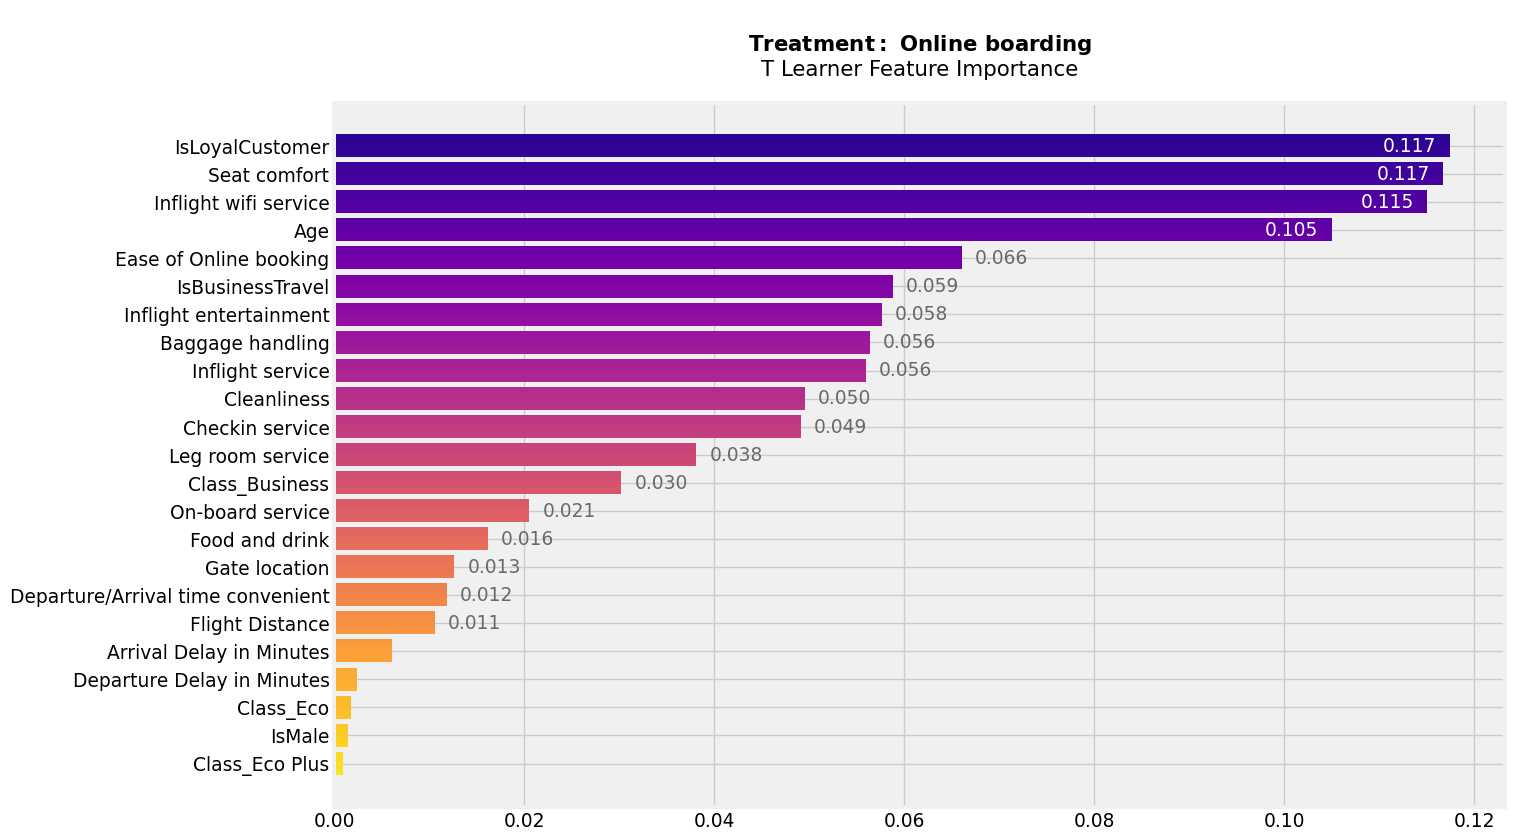

In [52]:
fig, ax = plt.subplots(figsize=(16,8), dpi = 96, facecolor = "white")

bar = ax.barh(importance["Good Online Boarding"].index, importance["Good Online Boarding"])
plt.gca().invert_yaxis()
plt.tight_layout()
plt.title("\n"+r"$\bf{Treatment:\ Online\ boarding}$"+"\n"+"T Learner Feature Importance", pad=20, fontsize=16)
ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:.2f}'))

def gradientbars_sliced(bars):
    ax = bars[0].axes
    xmin, xmax = ax.get_xlim()
    ymax, ymin = ax.get_ylim()
    for bar in bars:
        bar.set_zorder(1)
        bar.set_facecolor("none")
        x, y = bar.get_xy()
        w, h = bar.get_width(), bar.get_height()
        grad = np.linspace(y, y + h, 256).reshape(256, 1)
        ax.imshow(grad, extent=[x, x + w, y, y + h], aspect="auto", zorder=1, origin='lower',
                  vmin=ymin, vmax=ymax, cmap="plasma")
    ax.axis([xmin, xmax, ymax, ymin])

gradientbars_sliced(bar)

for rect in ax.patches:
    x_value = rect.get_width()
    y_value = rect.get_y() + rect.get_height() / 2
    if x_value > 0.01:
        if x_value < 0.1:
            space = 50
            ha = 'right'
            color = "dimgrey"
        else:
            space = -50
            ha = 'left'
            color = "white"

        label = '{:,.3f}'.format(x_value)

        plt.annotate(label, (x_value, y_value), xytext=(space, 0), textcoords='offset points',
                     va='center', ha=ha, color = color)

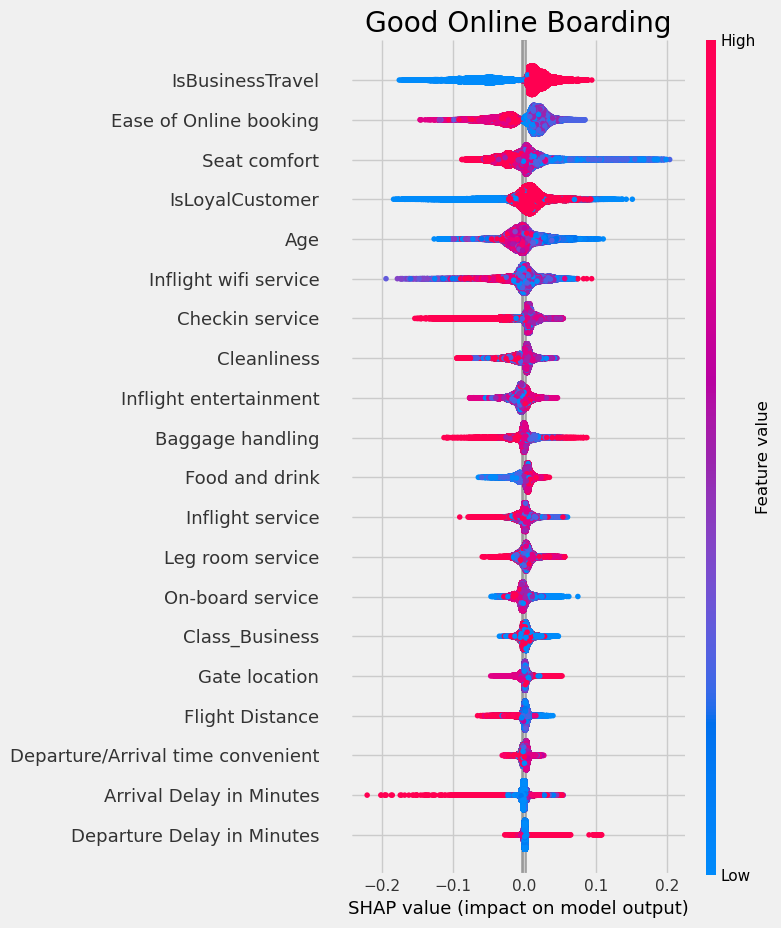

In [53]:
t_learner.plot_shap_values(X = X, tau = t_learner_tau, features = feature_names)

In [54]:
comparison.loc[len(comparison)] = result
display(comparison)

,Meta Learner,Base Model (Regressor),ATE,ATE lb,ATE ub,Top Features (auto)
0,S Learner,XGBoost,0.058765,NA,NA,"[Inflight wifi service, IsLoyalCustomer, IsBusinessTravel]"
1,T Learner,XGBoost,0.061308,0.059094,0.063522,"[IsLoyalCustomer, Seat comfort, Inflight wifi service]"


### 3. X Learner with XGBRegressor<a name = "e2x"></a>

In [55]:
x_learner = BaseXRegressor(XGBRegressor(n_jobs = -1), control_name = "Bad Online Boarding")
te, lb, ub = x_learner.estimate_ate(X, treatment, y)
result = ["X Learner", "XGBoost", te[0], lb[0], ub[0]]

In [56]:
x_learner_tau = x_learner.fit_predict(X, treatment, y)

importance = x_learner.get_importance(X = X,
                                      tau = x_learner_tau,
                                      normalize = True, 
                                      method = 'auto', 
                                      features = feature_names)
display(pd.DataFrame(importance).rename(columns = {"Good Online Boarding":"Importance"}))
result.append(list(pd.DataFrame(importance).iloc[:3,0].index))

,Importance
Seat comfort,0.130279
Age,0.104896
Inflight wifi service,0.092566
IsLoyalCustomer,0.085430
Baggage handling,0.070858
IsBusinessTravel,0.067768
Cleanliness,0.059764
Gate location,0.047421
Checkin service,0.045987
Departure/Arrival time convenient,0.042693


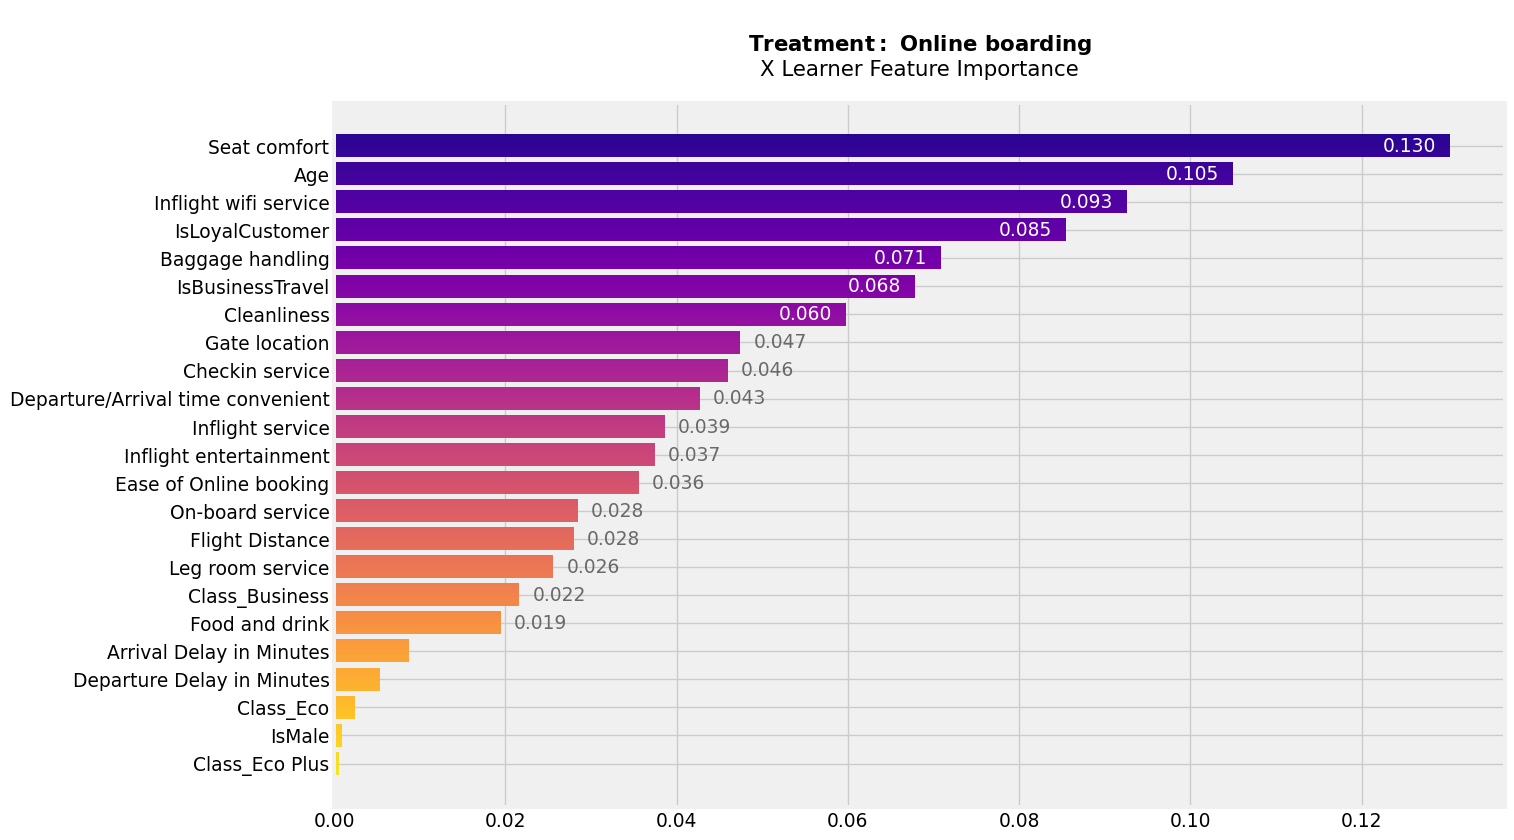

In [57]:
fig, ax = plt.subplots(figsize=(16,8), dpi = 96, facecolor = "white")

bar = ax.barh(importance["Good Online Boarding"].index, importance["Good Online Boarding"])
plt.gca().invert_yaxis()
plt.tight_layout()
plt.title("\n"+r"$\bf{Treatment:\ Online\ boarding}$"+"\n"+"X Learner Feature Importance", pad=20, fontsize=16)
ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:.2f}'))

def gradientbars_sliced(bars):
    ax = bars[0].axes
    xmin, xmax = ax.get_xlim()
    ymax, ymin = ax.get_ylim()
    for bar in bars:
        bar.set_zorder(1)
        bar.set_facecolor("none")
        x, y = bar.get_xy()
        w, h = bar.get_width(), bar.get_height()
        grad = np.linspace(y, y + h, 256).reshape(256, 1)
        ax.imshow(grad, extent=[x, x + w, y, y + h], aspect="auto", zorder=1, origin='lower',
                  vmin=ymin, vmax=ymax, cmap="plasma")
    ax.axis([xmin, xmax, ymax, ymin])

gradientbars_sliced(bar)

for rect in ax.patches:
    x_value = rect.get_width()
    y_value = rect.get_y() + rect.get_height() / 2
    if x_value > 0.01:
        if x_value < 0.05:
            space = 50
            ha = 'right'
            color = "dimgrey"
        else:
            space = -50
            ha = 'left'
            color = "white"

        label = '{:,.3f}'.format(x_value)

        plt.annotate(label, (x_value, y_value), xytext=(space, 0), textcoords='offset points',
                     va='center', ha=ha, color = color)

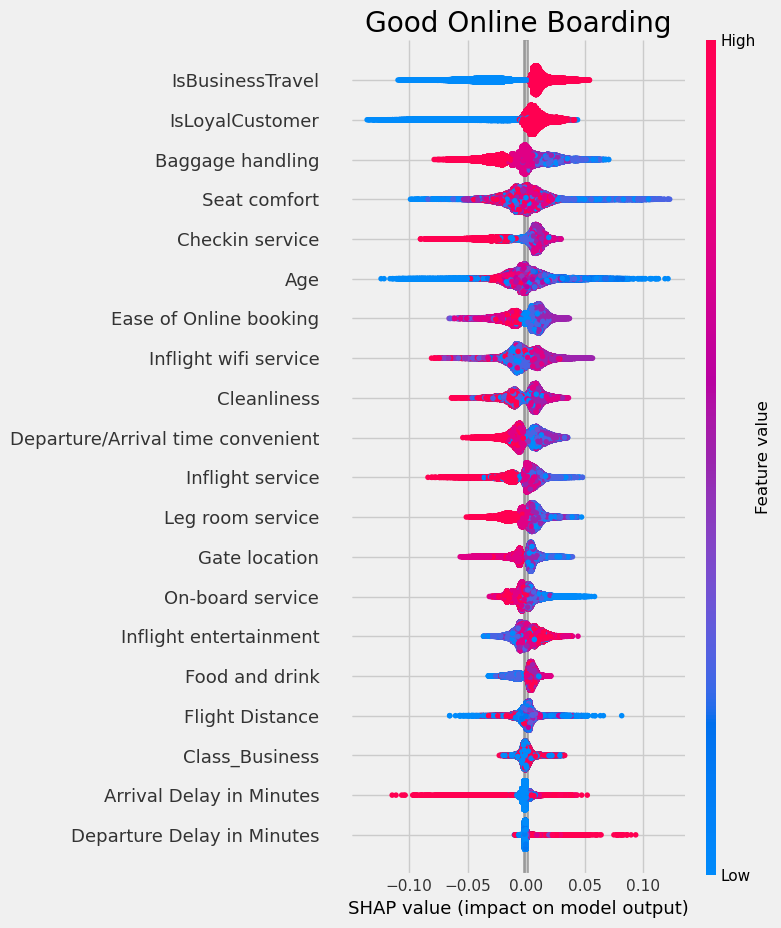

In [58]:
x_learner.plot_shap_values(X = X, tau = x_learner_tau, features = feature_names)

In [59]:
comparison.loc[len(comparison)] = result
display(comparison)

,Meta Learner,Base Model (Regressor),ATE,ATE lb,ATE ub,Top Features (auto)
0,S Learner,XGBoost,0.058765,NA,NA,"[Inflight wifi service, IsLoyalCustomer, IsBusinessTravel]"
1,T Learner,XGBoost,0.061308,0.059094,0.063522,"[IsLoyalCustomer, Seat comfort, Inflight wifi service]"
2,X Learner,XGBoost,0.038576,0.03655,0.040601,"[Seat comfort, Age, Inflight wifi service]"


## CATE II: Online boarding<a name = "c2"></a>

In [60]:
airplane_ITE_t = t_learner.fit_predict(X, treatment, y)
display(airplane_ITE_t)

array([[-0.05271201],
       [-0.05360588],
       [ 0.24359936],
       ...,
       [ 0.14285262],
       [ 0.40842846],
       [ 0.30538198]])

In [61]:
airplane_causal["ITE"] = airplane_ITE_t
display(airplane_causal.head())

,Departure Delay in Minutes,Arrival Delay in Minutes,IsMale,IsLoyalCustomer,IsBusinessTravel,Class_Business,Class_Eco,Class_Eco Plus,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Age,Flight Distance,satisfaction,ITE
0,25.0,18.0,1.0,1.0,0.0,0.0,0.0,1.0,3.0,4.0,3.0,1.0,5.0,3.0,5.0,5.0,4.0,3.0,4.0,4.0,5.0,5.0,13,460,0,-0.052712
1,1.0,6.0,1.0,0.0,1.0,1.0,0.0,0.0,3.0,2.0,3.0,3.0,1.0,3.0,1.0,1.0,1.0,5.0,3.0,1.0,4.0,1.0,25,235,0,-0.053606
2,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,2.0,2.0,2.0,2.0,5.0,5.0,5.0,5.0,4.0,3.0,4.0,4.0,4.0,5.0,26,1142,1,0.243599
3,11.0,9.0,0.0,1.0,1.0,1.0,0.0,0.0,2.0,5.0,5.0,5.0,2.0,2.0,2.0,2.0,2.0,5.0,3.0,1.0,4.0,2.0,25,562,0,0.241243
4,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,3.0,3.0,3.0,3.0,4.0,5.0,5.0,3.0,3.0,4.0,4.0,3.0,3.0,3.0,61,214,1,0.434027


### 1. By IsBusinessTravel<a name = "c2bu"></a>

In [62]:
CATE_bu = airplane_causal[["IsBusinessTravel", "ITE"]]
CATE_bu["IsBusinessTravel"] = np.where(CATE_bu["IsBusinessTravel"] == 1, "Yes", "No")
CATE_bu.groupby(["IsBusinessTravel"]).mean().rename(columns={"ITE":"CATE"}).style.pipe(make_pretty)

,CATE
IsBusinessTravel,
No,0.013
Yes,0.083


### 2. By IsLoyalCustomer<a name = "c2lo"></a>

In [63]:
CATE_lo = airplane_causal[["IsLoyalCustomer", "ITE"]]
CATE_lo["IsLoyalCustomer"] = np.where(CATE_lo["IsLoyalCustomer"] == 1, "Yes", "No")
CATE_lo.groupby(["IsLoyalCustomer"]).mean().rename(columns={"ITE":"CATE"}).style.pipe(make_pretty)

,CATE
IsLoyalCustomer,
No,0.067
Yes,0.06


### 3. By Age<a name = "c2age"></a>

In [64]:
CATE_age = airplane_causal[["Age", "ITE"]]
def ageGroup(x):
    if x < 15:
        return "0-15"
    elif x < 41:
        return "18-40"
    elif x < 66:
        return "41-65"
    else:
        return "65+"
CATE_age["Age"] = CATE_age["Age"].apply(lambda x: ageGroup(x))
CATE_age.groupby(["Age"]).mean().rename(columns={"ITE":"CATE"}).style.pipe(make_pretty)

,CATE
Age,
0-15,0.029
18-40,0.081
41-65,0.046
65+,0.038


### 4. Treatment Effect Visualization<a name = "c2v"></a>

In [65]:
CATE_vs = airplane_causal[["Flight Distance", "Age", "ITE"]]
CATE_vs["Flight Distance"] = CATE_vs["Flight Distance"].apply(lambda x: round(x/100)*100)
CATE_vs = CATE_vs.groupby(by = ["Flight Distance","Age"]).mean().reset_index()

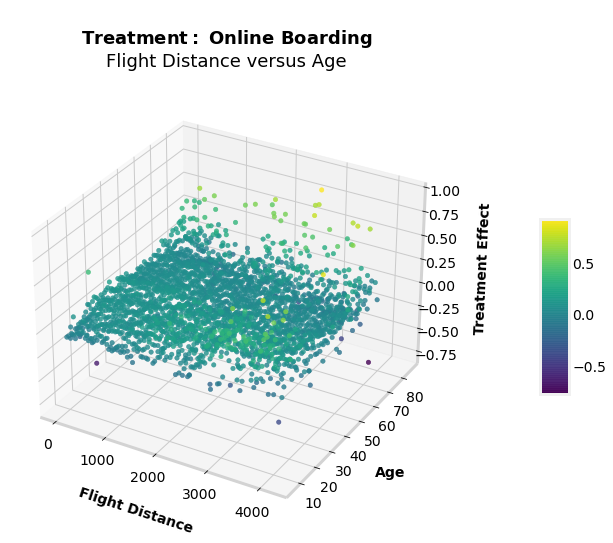

In [66]:
fig = plt.figure(figsize = (10, 10), dpi = 72)
ax = plt.axes(projection ="3d")

ax.grid(b = True, color ='grey', linestyle ='-.', linewidth = 0.3, alpha = 0.2)
my_cmap = plt.get_cmap('viridis')
 
sctt = ax.scatter3D(CATE_vs["Flight Distance"], CATE_vs["Age"], CATE_vs["ITE"],
                    alpha = 0.8,
                    c = CATE_vs["ITE"],
                    cmap = my_cmap)
 
plt.title("\n"+r"$\bf{Treatment:\ Online\ Boarding}$"+"\n"+"Flight Distance versus Age", pad=20, fontsize=18)

fig.set_facecolor("white")

ax.set_facecolor("white")
ax.w_xaxis.line.set_color("lightgrey")
ax.w_yaxis.line.set_color("lightgrey")
ax.w_zaxis.line.set_color("lightgrey")

ax.set_xlabel('\nFlight Distance', fontweight ='bold', fontsize = 14, labelpad = 12)
ax.set_ylabel('\nAge', fontweight ='bold', fontsize = 14, labelpad = 12)
ax.set_zlabel('\nTreatment Effect', fontweight ='bold', fontsize = 14, labelpad = 12)
fig.colorbar(sctt, ax = ax, shrink = 0.3, aspect = 6, pad = 0.15)

plt.show()